# Graph Neural Network for Human vs LLM Code Classification

This notebook implements a GIN (Graph Isomorphism Network) to distinguish between human-written and LLM-generated Python code using Abstract Syntax Tree (AST) representations.

## 1. Setup and Imports

In [38]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_auc_score, roc_curve


In [39]:
# Import custom modules
from graphdataset import CodeGraphDataset
from process import PythonCodeProcessor

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## 2. Data Loading and Exploration

In [40]:
# Configuration
DATA_DIR = 'dataset/python'
VALID_FILE = os.path.join(DATA_DIR, 'valid_no_comment.jsonl')
TEST_FILE = os.path.join(DATA_DIR, 'test_no_comment.jsonl')

MAX_NODES = 500  # Maximum nodes in AST
EMBEDDING_SIZE = 128  # Dimension of node embeddings
BATCH_SIZE = 32
LEARNING_RATE = 0.001
NUM_EPOCHS = 30
HIDDEN_DIM = 256
NUM_LAYERS = 5

# NEW: Optimization parameters
MAX_SAMPLES_TRAIN = 5000  # Limit training samples (None = all)
MAX_SAMPLES_TEST = 1000   # Limit test samples (None = all)
TIMEOUT_MINUTES = 150      # Stop processing after 10 minutes

print("Configuration:")
print(f"  Max nodes: {MAX_NODES}")
print(f"  Embedding size: {EMBEDDING_SIZE}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Epochs: {NUM_EPOCHS}")
print(f"  Hidden dim: {HIDDEN_DIM}")
print(f"  GIN layers: {NUM_LAYERS}")
print(f"  Max training samples: {MAX_SAMPLES_TRAIN}")
print(f"  Max test samples: {MAX_SAMPLES_TEST}")
print(f"  Timeout: {TIMEOUT_MINUTES} minutes")



Configuration:
  Max nodes: 500
  Embedding size: 128
  Batch size: 32
  Learning rate: 0.001
  Epochs: 30
  Hidden dim: 256
  GIN layers: 5
  Max training samples: 5000
  Max test samples: 1000
  Timeout: 150 minutes


In [41]:
from graphdataset import CodeGraphDataset
from process import PythonCodeProcessor

In [44]:
# Load datasets with limits and timeout
print("\n" + "="*70)
print("Loading validation dataset...")
print("="*70)
valid_dataset = CodeGraphDataset(
    jsonl_path=VALID_FILE,
    max_nodes=MAX_NODES,
    embedding_size=EMBEDDING_SIZE,
    force_reprocess=True,
    max_samples=MAX_SAMPLES_TRAIN,  # LIMIT SAMPLES
    timeout_minutes=TIMEOUT_MINUTES  # TIMEOUT
)

print("\n" + "="*70)
print("Loading test dataset (sharing vocabulary)...")
print("="*70)
test_dataset = CodeGraphDataset(
    jsonl_path=TEST_FILE,
    processor=valid_dataset.processor,  # Share vocabulary
    max_nodes=MAX_NODES,
    max_samples=MAX_SAMPLES_TEST,  # LIMIT SAMPLES
    timeout_minutes=TIMEOUT_MINUTES  # TIMEOUT
)

# print(f"\n{'='*70}")
# print(f"Validation set size: {len(valid_dataset)}")
# print(f"Test set size: {len(test_dataset)}")
# print(f"{'='*70}")


Loading validation dataset...
Processing graphs from dataset/python/valid_no_comment.jsonl
  Limiting to 5000 samples
  Timeout: 150 minutes
Loaded 5000 examples from dataset/python/valid_no_comment.jsonl
Extracting AST node sequences from corpus...


Extracting tokens:   0%|          | 0/50 [00:00<?, ?batch/s]

Syntax error in code: unindent does not match any outer indentation level (<unknown>, line 11)


Extracting tokens:   2%|▏         | 1/50 [00:29<24:28, 29.96s/batch]

Syntax error in code: EOL while scanning string literal (<unknown>, line 2)
Syntax error in code: expected an indented block (<unknown>, line 3)


Extracting tokens:   4%|▍         | 2/50 [00:54<21:14, 26.55s/batch]

Syntax error in code: unindent does not match any outer indentation level (<unknown>, line 7)


Extracting tokens:   6%|▌         | 3/50 [01:24<22:20, 28.52s/batch]

Syntax error in code: keyword argument repeated (<unknown>, line 6)
Syntax error in code: invalid syntax (<unknown>, line 5)


Extracting tokens:  10%|█         | 5/50 [02:13<19:28, 25.97s/batch]

Syntax error in code: unindent does not match any outer indentation level (<unknown>, line 11)
Syntax error in code: invalid syntax (<unknown>, line 51)


Extracting tokens:  12%|█▏        | 6/50 [02:44<20:22, 27.77s/batch]

Syntax error in code: EOL while scanning string literal (<unknown>, line 9)


Extracting tokens:  18%|█▊        | 9/50 [04:04<18:23, 26.92s/batch]

Syntax error in code: expected an indented block (<unknown>, line 3)
Syntax error in code: expected an indented block (<unknown>, line 5)
Syntax error in code: unexpected indent (<unknown>, line 3)


Extracting tokens:  20%|██        | 10/50 [04:35<18:45, 28.14s/batch]

Syntax error in code: expected an indented block (<unknown>, line 3)


Extracting tokens:  22%|██▏       | 11/50 [05:00<17:35, 27.06s/batch]

Syntax error in code: unexpected EOF while parsing (<unknown>, line 3)


Extracting tokens:  24%|██▍       | 12/50 [05:31<17:57, 28.34s/batch]

Syntax error in code: invalid syntax (<unknown>, line 4)
Syntax error in code: invalid syntax (<unknown>, line 12)


Extracting tokens:  26%|██▌       | 13/50 [05:56<16:48, 27.27s/batch]

Syntax error in code: invalid syntax (<unknown>, line 9)
Syntax error in code: unindent does not match any outer indentation level (<unknown>, line 4)
Syntax error in code: (unicode error) 'unicodeescape' codec can't decode bytes in position 0-1: malformed \N character escape (<unknown>, line 6)
Syntax error in code: invalid syntax (<unknown>, line 2)


Extracting tokens:  28%|██▊       | 14/50 [06:27<17:09, 28.59s/batch]

Syntax error in code: invalid syntax (<unknown>, line 12)


Extracting tokens:  30%|███       | 15/50 [06:52<15:56, 27.33s/batch]

Syntax error in code: EOF while scanning triple-quoted string literal (<unknown>, line 3)


Extracting tokens:  32%|███▏      | 16/50 [07:17<15:03, 26.59s/batch]

Syntax error in code: expected an indented block (<unknown>, line 2)
Syntax error in code: unindent does not match any outer indentation level (<unknown>, line 5)
Syntax error in code: invalid syntax (<unknown>, line 26)
Syntax error in code: invalid syntax (<unknown>, line 10)
Syntax error in code: invalid syntax (<unknown>, line 33)


Extracting tokens:  34%|███▍      | 17/50 [07:49<15:30, 28.19s/batch]

Syntax error in code: expected an indented block (<unknown>, line 3)
Syntax error in code: invalid syntax (<unknown>, line 7)


Extracting tokens:  36%|███▌      | 18/50 [08:13<14:24, 27.01s/batch]

Syntax error in code: unindent does not match any outer indentation level (<unknown>, line 9)


Extracting tokens:  38%|███▊      | 19/50 [08:44<14:30, 28.09s/batch]

Syntax error in code: unindent does not match any outer indentation level (<unknown>, line 14)
Syntax error in code: EOL while scanning string literal (<unknown>, line 2)
Syntax error in code: expected an indented block (<unknown>, line 3)


Extracting tokens:  40%|████      | 20/50 [09:08<13:26, 26.89s/batch]

Syntax error in code: invalid syntax (<unknown>, line 18)
Syntax error in code: invalid syntax (<unknown>, line 5)


Extracting tokens:  42%|████▏     | 21/50 [09:38<13:34, 28.07s/batch]

Syntax error in code: invalid syntax (<unknown>, line 1)
Syntax error in code: unindent does not match any outer indentation level (<unknown>, line 6)
Syntax error in code: unindent does not match any outer indentation level (<unknown>, line 6)


Extracting tokens:  46%|████▌     | 23/50 [10:33<12:35, 27.99s/batch]

Syntax error in code: EOL while scanning string literal (<unknown>, line 12)
Syntax error in code: expected an indented block (<unknown>, line 9)
Syntax error in code: invalid syntax (<unknown>, line 3)
Syntax error in code: unindent does not match any outer indentation level (<unknown>, line 5)


Extracting tokens:  48%|████▊     | 24/50 [10:58<11:39, 26.90s/batch]

Syntax error in code: invalid syntax (<unknown>, line 5)
Syntax error in code: expected an indented block (<unknown>, line 3)


Extracting tokens:  50%|█████     | 25/50 [11:22<10:51, 26.07s/batch]

Syntax error in code: expected an indented block (<unknown>, line 3)
Syntax error in code: EOL while scanning string literal (<unknown>, line 3)


Extracting tokens:  52%|█████▏    | 26/50 [11:53<11:02, 27.60s/batch]

Syntax error in code: invalid syntax (<unknown>, line 4)
Syntax error in code: expected an indented block (<unknown>, line 3)


Extracting tokens:  54%|█████▍    | 27/50 [12:17<10:09, 26.49s/batch]

Syntax error in code: invalid syntax (<unknown>, line 3)
Syntax error in code: invalid syntax (<unknown>, line 6)


Extracting tokens:  58%|█████▊    | 29/50 [13:12<09:24, 26.89s/batch]

Syntax error in code: unmatched ')' (<unknown>, line 21)
Syntax error in code: Generator expression must be parenthesized (<unknown>, line 26)
Syntax error in code: invalid syntax (<unknown>, line 11)


Extracting tokens:  60%|██████    | 30/50 [13:43<09:21, 28.08s/batch]

Syntax error in code: expected an indented block (<unknown>, line 3)
Syntax error in code: invalid syntax (<unknown>, line 47)


Extracting tokens:  64%|██████▍   | 32/50 [14:38<08:23, 27.96s/batch]

Syntax error in code: invalid syntax (<unknown>, line 4)
Syntax error in code: invalid syntax (<unknown>, line 20)


Extracting tokens:  66%|██████▌   | 33/50 [15:02<07:35, 26.82s/batch]

Syntax error in code: unindent does not match any outer indentation level (<unknown>, line 4)


Extracting tokens:  68%|██████▊   | 34/50 [15:26<06:56, 26.05s/batch]

Syntax error in code: unindent does not match any outer indentation level (<unknown>, line 10)
Syntax error in code: expected an indented block (<unknown>, line 3)
Syntax error in code: EOL while scanning string literal (<unknown>, line 182)
Syntax error in code: invalid syntax (<unknown>, line 11)


Extracting tokens:  70%|███████   | 35/50 [15:57<06:51, 27.45s/batch]

Syntax error in code: invalid syntax (<unknown>, line 2)


Extracting tokens:  72%|███████▏  | 36/50 [16:21<06:09, 26.43s/batch]

Syntax error in code: invalid syntax (<unknown>, line 4)
Syntax error in code: invalid syntax (<unknown>, line 23)


Extracting tokens:  74%|███████▍  | 37/50 [16:51<05:57, 27.51s/batch]

Syntax error in code: unindent does not match any outer indentation level (<unknown>, line 6)
Syntax error in code: invalid syntax (<unknown>, line 20)
Syntax error in code: unindent does not match any outer indentation level (<unknown>, line 5)


Extracting tokens:  76%|███████▌  | 38/50 [17:15<05:16, 26.33s/batch]

Syntax error in code: invalid syntax (<unknown>, line 1)
Syntax error in code: invalid syntax (<unknown>, line 5)


Extracting tokens:  78%|███████▊  | 39/50 [17:45<05:03, 27.61s/batch]

Syntax error in code: invalid syntax (<unknown>, line 7)


Extracting tokens:  84%|████████▍ | 42/50 [19:05<03:34, 26.80s/batch]

Syntax error in code: invalid syntax (<unknown>, line 2)
Syntax error in code: invalid syntax (<unknown>, line 1)


Extracting tokens:  86%|████████▌ | 43/50 [19:28<03:01, 25.90s/batch]

Syntax error in code: unindent does not match any outer indentation level (<unknown>, line 8)


Extracting tokens:  88%|████████▊ | 44/50 [19:59<02:43, 27.29s/batch]

Syntax error in code: invalid syntax (<unknown>, line 2)
Syntax error in code: unindent does not match any outer indentation level (<unknown>, line 4)
Syntax error in code: invalid syntax (<unknown>, line 7)


Extracting tokens:  90%|█████████ | 45/50 [20:23<02:11, 26.30s/batch]

Syntax error in code: unindent does not match any outer indentation level (<unknown>, line 4)
Syntax error in code: invalid syntax (<unknown>, line 1)
Syntax error in code: invalid syntax (<unknown>, line 13)


Extracting tokens:  94%|█████████▍| 47/50 [21:17<01:19, 26.41s/batch]

Syntax error in code: expected an indented block (<unknown>, line 4)


Extracting tokens:  98%|█████████▊| 49/50 [22:11<00:26, 26.23s/batch]

Syntax error in code: expected an indented block (<unknown>, line 8)
Syntax error in code: expected an indented block (<unknown>, line 3)


Extracting tokens: 100%|██████████| 50/50 [22:40<00:00, 27.21s/batch]

Syntax error in code: unindent does not match any outer indentation level (<unknown>, line 13)
Total token sequences for embedding: 9877
Training Word2Vec embeddings on AST tokens...


Vocabulary size: 379007
Processing code into graphs...


Processing samples:   1%|          | 54/5000 [00:55<1:10:11,  1.17sample/s]

Syntax error in code: unindent does not match any outer indentation level (<unknown>, line 11)


Processing samples:   2%|▏         | 114/5000 [02:02<1:59:55,  1.47s/sample]

Syntax error in code: EOL while scanning string literal (<unknown>, line 2)


Processing samples:   3%|▎         | 132/5000 [02:17<43:01,  1.89sample/s]  

Syntax error in code: expected an indented block (<unknown>, line 3)


Processing samples:   5%|▍         | 247/5000 [04:19<38:33,  2.05sample/s]  

Syntax error in code: unindent does not match any outer indentation level (<unknown>, line 7)


Processing samples:   6%|▌         | 302/5000 [05:24<2:26:33,  1.87s/sample]

Syntax error in code: keyword argument repeated (<unknown>, line 6)


Processing samples:   7%|▋         | 362/5000 [06:23<45:38,  1.69sample/s]  

Syntax error in code: invalid syntax (<unknown>, line 5)


Processing samples:  11%|█         | 557/5000 [09:57<1:57:47,  1.59s/sample]

Syntax error in code: unindent does not match any outer indentation level (<unknown>, line 11)


Processing samples:  12%|█▏        | 584/5000 [10:23<1:30:44,  1.23s/sample]

Syntax error in code: invalid syntax (<unknown>, line 51)


Processing samples:  14%|█▍        | 697/5000 [12:18<1:07:00,  1.07sample/s]

Syntax error in code: EOL while scanning string literal (<unknown>, line 9)


Processing samples:  19%|█▉        | 952/5000 [16:43<1:05:55,  1.02sample/s]

Syntax error in code: expected an indented block (<unknown>, line 3)


Processing samples:  19%|█▉        | 956/5000 [16:45<35:53,  1.88sample/s]  

Syntax error in code: expected an indented block (<unknown>, line 5)


Processing samples:  20%|█▉        | 980/5000 [17:11<47:21,  1.41sample/s]  

Syntax error in code: unexpected indent (<unknown>, line 3)


Processing samples:  22%|██▏       | 1080/5000 [19:01<2:53:50,  2.66s/sample]

Syntax error in code: expected an indented block (<unknown>, line 3)


Processing samples:  23%|██▎       | 1160/5000 [20:13<27:17,  2.35sample/s]  

Syntax error in code: unexpected EOF while parsing (<unknown>, line 3)


Processing samples:  25%|██▍       | 1244/5000 [21:46<2:57:32,  2.84s/sample]

Syntax error in code: invalid syntax (<unknown>, line 4)
Syntax error in code: invalid syntax (<unknown>, line 12)


Processing samples:  27%|██▋       | 1332/5000 [23:13<1:17:56,  1.27s/sample]

Syntax error in code: invalid syntax (<unknown>, line 9)


Processing samples:  27%|██▋       | 1333/5000 [23:13<59:34,  1.03sample/s]  

Syntax error in code: unindent does not match any outer indentation level (<unknown>, line 4)


Processing samples:  27%|██▋       | 1363/5000 [23:42<50:47,  1.19sample/s]  

Syntax error in code: (unicode error) 'unicodeescape' codec can't decode bytes in position 0-1: malformed \N character escape (<unknown>, line 6)


Processing samples:  28%|██▊       | 1398/5000 [24:14<26:47,  2.24sample/s]  

Syntax error in code: invalid syntax (<unknown>, line 2)


Processing samples:  28%|██▊       | 1418/5000 [24:39<1:18:28,  1.31s/sample]

Syntax error in code: invalid syntax (<unknown>, line 12)


Processing samples:  31%|███       | 1561/5000 [27:02<1:32:41,  1.62s/sample]

Syntax error in code: EOF while scanning triple-quoted string literal (<unknown>, line 3)


Processing samples:  32%|███▏      | 1618/5000 [27:51<22:55,  2.46sample/s]  

Syntax error in code: expected an indented block (<unknown>, line 2)


Processing samples:  33%|███▎      | 1644/5000 [28:18<25:54,  2.16sample/s]  

Syntax error in code: unindent does not match any outer indentation level (<unknown>, line 5)


Processing samples:  33%|███▎      | 1651/5000 [28:28<1:22:19,  1.47s/sample]

Syntax error in code: invalid syntax (<unknown>, line 26)


Processing samples:  34%|███▎      | 1681/5000 [28:57<1:22:31,  1.49s/sample]

Syntax error in code: invalid syntax (<unknown>, line 10)


Processing samples:  34%|███▍      | 1694/5000 [29:10<2:30:11,  2.73s/sample]

Syntax error in code: invalid syntax (<unknown>, line 33)


Processing samples:  35%|███▍      | 1732/5000 [29:43<31:36,  1.72sample/s]  

Syntax error in code: expected an indented block (<unknown>, line 3)


Processing samples:  35%|███▌      | 1762/5000 [30:10<31:40,  1.70sample/s]  

Syntax error in code: invalid syntax (<unknown>, line 7)


Processing samples:  38%|███▊      | 1880/5000 [32:07<1:05:06,  1.25s/sample]

Syntax error in code: unindent does not match any outer indentation level (<unknown>, line 9)


Processing samples:  39%|███▊      | 1930/5000 [32:53<37:37,  1.36sample/s]  

Syntax error in code: unindent does not match any outer indentation level (<unknown>, line 14)


Processing samples:  39%|███▉      | 1945/5000 [33:07<42:45,  1.19sample/s]  

Syntax error in code: EOL while scanning string literal (<unknown>, line 2)


Processing samples:  39%|███▉      | 1949/5000 [33:09<26:08,  1.94sample/s]

Syntax error in code: expected an indented block (<unknown>, line 3)


Processing samples:  41%|████      | 2059/5000 [34:52<26:52,  1.82sample/s]  

Syntax error in code: invalid syntax (<unknown>, line 18)


Processing samples:  41%|████▏     | 2063/5000 [34:54<23:01,  2.13sample/s]

Syntax error in code: invalid syntax (<unknown>, line 5)


Processing samples:  43%|████▎     | 2132/5000 [36:06<1:45:25,  2.21s/sample]

Syntax error in code: invalid syntax (<unknown>, line 1)


Processing samples:  43%|████▎     | 2158/5000 [36:26<24:25,  1.94sample/s]  

Syntax error in code: unindent does not match any outer indentation level (<unknown>, line 6)


Processing samples:  43%|████▎     | 2167/5000 [36:37<1:12:50,  1.54s/sample]

Syntax error in code: unindent does not match any outer indentation level (<unknown>, line 6)


Processing samples:  46%|████▌     | 2299/5000 [38:42<47:49,  1.06s/sample]  

Syntax error in code: EOL while scanning string literal (<unknown>, line 12)


Processing samples:  46%|████▌     | 2303/5000 [38:44<24:09,  1.86sample/s]

Syntax error in code: expected an indented block (<unknown>, line 9)


Processing samples:  46%|████▋     | 2314/5000 [38:57<1:12:03,  1.61s/sample]

Syntax error in code: invalid syntax (<unknown>, line 3)


Processing samples:  47%|████▋     | 2328/5000 [39:03<17:46,  2.50sample/s]  

Syntax error in code: unindent does not match any outer indentation level (<unknown>, line 5)


Processing samples:  48%|████▊     | 2423/5000 [40:35<19:14,  2.23sample/s]  

Syntax error in code: invalid syntax (<unknown>, line 5)


Processing samples:  50%|████▉     | 2495/5000 [41:50<1:32:00,  2.20s/sample]

Syntax error in code: expected an indented block (<unknown>, line 3)


Processing samples:  50%|█████     | 2514/5000 [42:06<1:08:29,  1.65s/sample]

Syntax error in code: expected an indented block (<unknown>, line 3)


Processing samples:  51%|█████▏    | 2573/5000 [42:57<19:09,  2.11sample/s]  

Syntax error in code: EOL while scanning string literal (<unknown>, line 3)


Processing samples:  52%|█████▏    | 2605/5000 [43:28<24:03,  1.66sample/s]  

Syntax error in code: invalid syntax (<unknown>, line 4)


Processing samples:  53%|█████▎    | 2630/5000 [43:49<18:43,  2.11sample/s]  

Syntax error in code: expected an indented block (<unknown>, line 3)


Processing samples:  55%|█████▌    | 2764/5000 [46:03<25:01,  1.49sample/s]  

Syntax error in code: invalid syntax (<unknown>, line 3)


Processing samples:  56%|█████▌    | 2795/5000 [46:34<1:02:33,  1.70s/sample]

Syntax error in code: invalid syntax (<unknown>, line 6)


Processing samples:  59%|█████▉    | 2964/5000 [49:22<20:37,  1.65sample/s]  

Syntax error in code: unmatched ')' (<unknown>, line 21)


Processing samples:  60%|█████▉    | 2977/5000 [49:39<53:59,  1.60s/sample]  

Syntax error in code: Generator expression must be parenthesized (<unknown>, line 26)


Processing samples:  60%|█████▉    | 2983/5000 [49:41<21:01,  1.60sample/s]

Syntax error in code: invalid syntax (<unknown>, line 11)


Processing samples:  60%|█████▉    | 2998/5000 [49:59<34:35,  1.04s/sample]  

Syntax error in code: expected an indented block (<unknown>, line 3)


Processing samples:  61%|██████▏   | 3070/5000 [51:16<40:49,  1.27s/sample]  

Syntax error in code: invalid syntax (<unknown>, line 47)


Processing samples:  65%|██████▍   | 3232/5000 [53:57<13:43,  2.15sample/s]  

Syntax error in code: invalid syntax (<unknown>, line 4)


Processing samples:  65%|██████▍   | 3239/5000 [54:11<35:13,  1.20s/sample]  

Syntax error in code: invalid syntax (<unknown>, line 20)


Processing samples:  66%|██████▌   | 3302/5000 [55:13<16:49,  1.68sample/s]  

Syntax error in code: unindent does not match any outer indentation level (<unknown>, line 4)


Processing samples:  68%|██████▊   | 3409/5000 [57:07<1:36:21,  3.63s/sample]

Syntax error in code: unindent does not match any outer indentation level (<unknown>, line 10)


Processing samples:  68%|██████▊   | 3419/5000 [57:11<13:41,  1.92sample/s]  

Syntax error in code: expected an indented block (<unknown>, line 3)


Processing samples:  69%|██████▊   | 3437/5000 [57:30<16:34,  1.57sample/s]  

Syntax error in code: EOL while scanning string literal (<unknown>, line 182)


Processing samples:  69%|██████▉   | 3444/5000 [57:33<10:28,  2.47sample/s]

Syntax error in code: invalid syntax (<unknown>, line 11)


Processing samples:  72%|███████▏  | 3595/5000 [1:00:11<15:05,  1.55sample/s]  

Syntax error in code: invalid syntax (<unknown>, line 2)


Processing samples:  72%|███████▏  | 3599/5000 [1:00:12<09:39,  2.42sample/s]

Syntax error in code: invalid syntax (<unknown>, line 4)


Processing samples:  72%|███████▏  | 3609/5000 [1:00:28<1:05:05,  2.81s/sample]

Syntax error in code: invalid syntax (<unknown>, line 23)


Processing samples:  75%|███████▍  | 3748/5000 [1:02:51<1:21:24,  3.90s/sample]

Syntax error in code: unindent does not match any outer indentation level (<unknown>, line 6)


Processing samples:  75%|███████▌  | 3759/5000 [1:02:55<11:21,  1.82sample/s]  

Syntax error in code: invalid syntax (<unknown>, line 20)


Processing samples:  75%|███████▌  | 3770/5000 [1:03:11<1:18:17,  3.82s/sample]

Syntax error in code: unindent does not match any outer indentation level (<unknown>, line 5)


Processing samples:  76%|███████▌  | 3802/5000 [1:03:37<09:34,  2.08sample/s]  

Syntax error in code: invalid syntax (<unknown>, line 1)


Processing samples:  78%|███████▊  | 3882/5000 [1:04:59<09:22,  1.99sample/s]  

Syntax error in code: invalid syntax (<unknown>, line 5)


Processing samples:  80%|███████▉  | 3984/5000 [1:06:42<09:14,  1.83sample/s]  

Syntax error in code: invalid syntax (<unknown>, line 7)


Processing samples:  84%|████████▍ | 4199/5000 [1:10:16<06:05,  2.19sample/s]  

Syntax error in code: invalid syntax (<unknown>, line 2)


Processing samples:  85%|████████▌ | 4254/5000 [1:11:16<07:34,  1.64sample/s]

Syntax error in code: invalid syntax (<unknown>, line 1)


Processing samples:  88%|████████▊ | 4396/5000 [1:13:33<03:57,  2.54sample/s]

Syntax error in code: unindent does not match any outer indentation level (<unknown>, line 8)


Processing samples:  89%|████████▊ | 4429/5000 [1:14:12<04:54,  1.94sample/s]

Syntax error in code: invalid syntax (<unknown>, line 2)


Processing samples:  89%|████████▊ | 4435/5000 [1:14:15<04:19,  2.18sample/s]

Syntax error in code: unindent does not match any outer indentation level (<unknown>, line 4)


Processing samples:  89%|████████▉ | 4444/5000 [1:14:31<19:59,  2.16s/sample]

Syntax error in code: invalid syntax (<unknown>, line 7)


Processing samples:  91%|█████████ | 4527/5000 [1:15:44<03:10,  2.48sample/s]

Syntax error in code: unindent does not match any outer indentation level (<unknown>, line 4)


Processing samples:  91%|█████████ | 4546/5000 [1:16:05<03:07,  2.43sample/s]

Syntax error in code: invalid syntax (<unknown>, line 1)


Processing samples:  92%|█████████▏| 4595/5000 [1:16:52<03:03,  2.21sample/s]

Syntax error in code: invalid syntax (<unknown>, line 13)


Processing samples:  95%|█████████▍| 4729/5000 [1:19:09<01:48,  2.51sample/s]

Syntax error in code: expected an indented block (<unknown>, line 4)


Processing samples:  99%|█████████▊| 4934/5000 [1:22:40<00:26,  2.53sample/s]

Syntax error in code: expected an indented block (<unknown>, line 8)


Processing samples:  99%|█████████▉| 4965/5000 [1:23:20<00:31,  1.10sample/s]

Syntax error in code: expected an indented block (<unknown>, line 3)


Processing samples: 100%|█████████▉| 4998/5000 [1:23:48<00:00,  2.10sample/s]

Syntax error in code: unindent does not match any outer indentation level (<unknown>, line 13)


Processing samples: 100%|██████████| 5000/5000 [1:23:48<00:00,  1.01s/sample]


Successfully processed 4916 examples
Failed to process 84 examples
Saving to cache: dataset/python/cached_graphs/valid_no_comment_n5000_graphs.pkl
Cache saved successfully

Loading test dataset (sharing vocabulary)...
Loading cached graphs from dataset/python/cached_graphs/test_no_comment_n1000_graphs.pkl
Loaded 974 cached examples
Vocabulary size: 345772


In [45]:
# Display dataset statistics
print("\n" + "="*70)
print("VALIDATION DATASET STATISTICS")
print("="*70)
valid_stats = valid_dataset.get_stats()
for key, value in valid_stats.items():
    if isinstance(value, float):
        print(f"{key}: {value:.2f}")
    else:
        print(f"{key}: {value}")

print("\n" + "="*70)
print("TEST DATASET STATISTICS")
print("="*70)
test_stats = test_dataset.get_stats()
for key, value in test_stats.items():
    if isinstance(value, float):
        print(f"{key}: {value:.2f}")
    else:
        print(f"{key}: {value}")


VALIDATION DATASET STATISTICS
total_samples: 4916
avg_code_nodes: 49.43
max_code_nodes: 1982
min_code_nodes: 4
avg_contrast_nodes: 48.99
max_contrast_nodes: 1420
min_contrast_nodes: 4
label_distribution: {'label_0': 2473, 'label_1': 2443}

TEST DATASET STATISTICS
total_samples: 974
avg_code_nodes: 47.85
max_code_nodes: 682
min_code_nodes: 5
avg_contrast_nodes: 46.18
max_contrast_nodes: 947
min_contrast_nodes: 5
label_distribution: {'label_0': 479, 'label_1': 495}


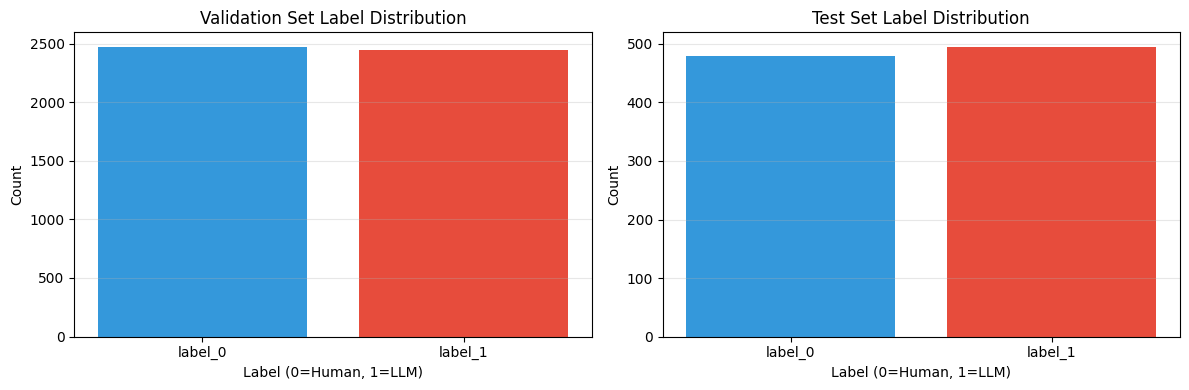

In [46]:
# Visualize label distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Validation set
valid_labels = valid_stats['label_distribution']
axes[0].bar(valid_labels.keys(), valid_labels.values(), color=['#3498db', '#e74c3c'])
axes[0].set_title('Validation Set Label Distribution')
axes[0].set_xlabel('Label (0=Human, 1=LLM)')
axes[0].set_ylabel('Count')
axes[0].grid(axis='y', alpha=0.3)

# Test set
test_labels = test_stats['label_distribution']
axes[1].bar(test_labels.keys(), test_labels.values(), color=['#3498db', '#e74c3c'])
axes[1].set_title('Test Set Label Distribution')
axes[1].set_xlabel('Label (0=Human, 1=LLM)')
axes[1].set_ylabel('Count')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('label_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

In [47]:
# Examine a sample
sample = valid_dataset[0]
print("\n" + "="*70)
print("SAMPLE DATA POINT")
print("="*70)
print(f"Index: {sample['index']}")
print(f"Label: {sample['label'].item()} ({'Human' if sample['label'].item() == 0 else 'LLM'})")
print(f"\nCode Graph:")
print(f"  Shape: {sample['code_graph'].shape}")
print(f"  Number of nodes: {sample['code_num_nodes']}")
print(f"  Sequence length: {len(sample['code_sequence'])}")
print(f"  First 15 tokens: {sample['code_sequence'][:15]}")
print(f"\nContrast Graph:")
print(f"  Shape: {sample['contrast_graph'].shape}")
print(f"  Number of nodes: {sample['contrast_num_nodes']}")
print(f"  Sequence length: {len(sample['contrast_sequence'])}")
print(f"  First 15 tokens: {sample['contrast_sequence'][:15]}")


SAMPLE DATA POINT
Index: gp266290
Label: 1 (LLM)

Code Graph:
  Shape: torch.Size([12, 12])
  Number of nodes: 12
  Sequence length: 17
  First 15 tokens: [345772, 345772, 345772, 345772, 345772, 2, 1, 0, 345772, 3, 0, 4, 0, 345772, 2]

Contrast Graph:
  Shape: torch.Size([45, 45])
  Number of nodes: 45
  Sequence length: 69
  First 15 tokens: [345772, 345772, 345772, 345772, 345772, 345772, 345772, 345772, 3, 0, 0, 345772, 345772, 345772, 0]


In [48]:
# Get embedding matrix
embedding_matrix = valid_dataset.get_embedding_matrix()
print(f"\nEmbedding matrix shape: {embedding_matrix.shape}")
print(f"Vocabulary size: {embedding_matrix.shape[0] - 1}")


Embedding matrix shape: torch.Size([345773, 128])
Vocabulary size: 345772


## 3. GIN Model Architecture

In [49]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GINLayer(nn.Module):
    """Graph Isomorphism Network Layer.
    
    Implements: h_v^(k) = MLP^(k)((1 + epsilon^(k)) * h_v^(k-1) + sum_{u in N(v)} h_u^(k-1))
    """
    def __init__(self, input_dim, hidden_dim, output_dim, eps_learnable=True):
        super(GINLayer, self).__init__()
        
        # MLP for node update
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
            nn.BatchNorm1d(output_dim),
            nn.ReLU()
        )
        
        # Learnable epsilon parameter
        if eps_learnable:
            self.eps = nn.Parameter(torch.zeros(1))
        else:
            self.register_buffer('eps', torch.zeros(1))
    
    def forward(self, x, adj):
        """
        Args:
            x: Node features [batch_size, num_nodes, feature_dim]
            adj: Adjacency matrix [batch_size, num_nodes, num_nodes]
        
        Returns:
            Updated node features [batch_size, num_nodes, output_dim]
        """
        # Extract dimensions FIRST (critical!)
        batch_size, num_nodes, feature_dim = x.size()
        
        # Aggregate neighbor features: sum_{u in N(v)} h_u
        neighbor_sum = torch.bmm(adj, x)  # [batch_size, num_nodes, feature_dim]
        
        # Remove self-loop from aggregation (we'll add it back with epsilon)
        # Create diagonal mask for each batch
        eye = torch.eye(num_nodes, device=adj.device).unsqueeze(0).expand(batch_size, -1, -1)
        self_features = torch.bmm(eye, x)
        neighbor_sum = neighbor_sum - self_features
        
        # Apply GIN update rule: (1 + eps) * h + sum(neighbors)
        out = (1 + self.eps) * x + neighbor_sum
        
        # Apply MLP
        out = out.view(batch_size * num_nodes, feature_dim)
        out = self.mlp(out)
        out = out.view(batch_size, num_nodes, -1)
        
        return out


class GINNetwork(nn.Module):
    """Graph Isomorphism Network for code classification."""
    
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, 
                 num_classes=2, dropout=0.3, pretrained_embeddings=None):
        super(GINNetwork, self).__init__()
        
        self.num_layers = num_layers
        self.dropout = dropout
        
        # Token embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        if pretrained_embeddings is not None:
            self.embedding.weight.data.copy_(pretrained_embeddings)
            # Optionally freeze embeddings
            # self.embedding.weight.requires_grad = False
        
        # GIN layers
        self.gin_layers = nn.ModuleList()
        
        # First layer
        self.gin_layers.append(
            GINLayer(embedding_dim, hidden_dim, hidden_dim, eps_learnable=True)
        )
        
        # Hidden layers
        for _ in range(num_layers - 1):
            self.gin_layers.append(
                GINLayer(hidden_dim, hidden_dim, hidden_dim, eps_learnable=True)
            )
        
        # Readout MLP (for graph-level classification)
        self.readout = nn.Sequential(
            nn.Linear(hidden_dim * num_layers, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_classes)
        )
    
    def forward(self, sequences, adj_matrices, num_nodes_list):
        """
        Args:
            sequences: LIST of token sequences (Python lists!)
            adj_matrices: Adjacency matrices [batch_size, max_nodes, max_nodes]
            num_nodes_list: List of actual number of nodes
        
        Returns:
            logits: [batch_size, num_classes]
        """
        batch_size = adj_matrices.size(0)
        max_nodes = adj_matrices.size(1)
        
        # FIX: Convert list of sequences to padded tensor
        node_features = torch.zeros(batch_size, max_nodes, dtype=torch.long, 
                                    device=adj_matrices.device)
        
        for i, seq in enumerate(sequences):
            seq_len = min(len(seq), max_nodes)
            node_features[i, :seq_len] = torch.tensor(seq[:seq_len], 
                                                    dtype=torch.long, 
                                                    device=adj_matrices.device)
        
        # Embed tokens
        x = self.embedding(node_features)
        
        # Apply GIN layers
        layer_outputs = []
        for layer in self.gin_layers:
            x = layer(x, adj_matrices)
            x = F.dropout(x, p=self.dropout, training=self.training)
            layer_outputs.append(x)
        
        # Graph-level readout with masking
        graph_representations = []
        for layer_out in layer_outputs:
            mask = torch.zeros(batch_size, max_nodes, 1, device=layer_out.device)
            for i, num_nodes in enumerate(num_nodes_list):
                mask[i, :num_nodes, :] = 1.0
            
            masked_out = layer_out * mask
            graph_rep = masked_out.sum(dim=1)
            graph_representations.append(graph_rep)
        
        # Concatenate and classify
        graph_rep = torch.cat(graph_representations, dim=1)
        logits = self.readout(graph_rep)
        
        return logits


class SiameseGNN(nn.Module):
    """Siamese network for comparing code and contrast samples."""
    
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers,
                 num_classes=2, dropout=0.3, pretrained_embeddings=None):
        super(SiameseGNN, self).__init__()
        
        # Shared GNN encoder
        self.gnn = GINNetwork(
            vocab_size=vocab_size,
            embedding_dim=embedding_dim,
            hidden_dim=hidden_dim,
            num_layers=num_layers,
            num_classes=hidden_dim * num_layers,  # Output embedding instead of class
            dropout=dropout,
            pretrained_embeddings=pretrained_embeddings
        )
        
        # Classifier on combined representations
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim * num_layers * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_classes)
        )
    
    def forward(self, code_seq, code_adj, code_num_nodes,
                contrast_seq, contrast_adj, contrast_num_nodes):
        """
        Args:
            code_seq: Token sequences for code [batch_size, max_seq_len]
            code_adj: Adjacency matrices for code [batch_size, max_nodes, max_nodes]
            code_num_nodes: Number of nodes for each code graph [batch_size]
            contrast_seq: Token sequences for contrast [batch_size, max_seq_len]
            contrast_adj: Adjacency matrices for contrast [batch_size, max_nodes, max_nodes]
            contrast_num_nodes: Number of nodes for each contrast graph [batch_size]
        
        Returns:
            logits: [batch_size, num_classes]
        """
        # Encode both graphs
        code_embedding = self.gnn(code_seq, code_adj, code_num_nodes)
        contrast_embedding = self.gnn(contrast_seq, contrast_adj, contrast_num_nodes)
        
        # Concatenate embeddings
        combined = torch.cat([code_embedding, contrast_embedding], dim=1)
        
        # Classify
        logits = self.classifier(combined)
        
        return logits


print("GIN Model Architecture defined successfully!")

GIN Model Architecture defined successfully!


## 4. Training Setup

In [50]:
def collate_code_batch(batch):
    """Collate function with padding for variable-size adjacency matrices."""

    # Labels & indices
    indices = [item['index'] for item in batch]
    labels = torch.stack([item['label'] for item in batch])

    # --------------------------
    # 1) Find max graph sizes
    # --------------------------
    max_code_nodes = max(item['code_graph'].shape[0] for item in batch)
    max_contrast_nodes = max(item['contrast_graph'].shape[0] for item in batch)

    # --------------------------
    # 2) Padding helper
    # --------------------------
    def pad_graph(adj, max_n):
        """Pad adjacency matrix to (max_n, max_n)."""
        out = torch.zeros((max_n, max_n), dtype=adj.dtype)
        n = adj.shape[0]
        out[:n, :n] = adj
        return out

    # --------------------------
    # 3) Pad and stack graphs
    # --------------------------
    code_graphs = torch.stack([
        pad_graph(item['code_graph'], max_code_nodes)
        for item in batch
    ])

    contrast_graphs = torch.stack([
        pad_graph(item['contrast_graph'], max_contrast_nodes)
        for item in batch
    ])

    # --------------------------
    # 4) Pass through sequences and node counts unchanged
    # --------------------------
    code_num_nodes = [item['code_num_nodes'] for item in batch]
    contrast_num_nodes = [item['contrast_num_nodes'] for item in batch]
    code_sequences = [item['code_sequence'] for item in batch]
    contrast_sequences = [item['contrast_sequence'] for item in batch]

    # --------------------------
    # 5) Return batch dict
    # --------------------------
    return {
        'index': indices,
        'label': labels,
        'code_graph': code_graphs,
        'contrast_graph': contrast_graphs,
        'code_num_nodes': code_num_nodes,
        'contrast_num_nodes': contrast_num_nodes,
        'code_sequence': code_sequences,
        'contrast_sequence': contrast_sequences,
    }


In [51]:
# def collate_code_batch(batch):
#     """Custom collate function to handle variable-length sequences."""
#     indices = [item['index'] for item in batch]
#     labels = torch.stack([item['label'] for item in batch])
#     code_graphs = torch.stack([item['code_graph'] for item in batch])
#     contrast_graphs = torch.stack([item['contrast_graph'] for item in batch])
#     code_num_nodes = [item['code_num_nodes'] for item in batch]
#     contrast_num_nodes = [item['contrast_num_nodes'] for item in batch]
#     code_sequences = [item['code_sequence'] for item in batch]
#     contrast_sequences = [item['contrast_sequence'] for item in batch]
    
#     return {
#         'index': indices,
#         'label': labels,
#         'code_graph': code_graphs,
#         'contrast_graph': contrast_graphs,
#         'code_num_nodes': code_num_nodes,
#         'contrast_num_nodes': contrast_num_nodes,
#         'code_sequence': code_sequences,
#         'contrast_sequence': contrast_sequences
#     }

# Create data loaders WITH CUSTOM COLLATE FUNCTION
train_loader = DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    collate_fn=collate_code_batch  # ← KEY FIX
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_code_batch  # ← KEY FIX
)

print(f"Train batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")

Train batches: 154
Test batches: 31


In [52]:
# Initialize model
vocab_size = embedding_matrix.shape[0]

model = SiameseGNN(
    vocab_size=vocab_size,
    embedding_dim=EMBEDDING_SIZE,
    hidden_dim=HIDDEN_DIM,
    num_layers=NUM_LAYERS,
    num_classes=2,
    dropout=0.3,
    pretrained_embeddings=embedding_matrix
).to(device)

print(f"\nModel initialized with {sum(p.numel() for p in model.parameters()):,} parameters")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")


Model initialized with 46,202,247 parameters
Trainable parameters: 46,202,247


In [53]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=5, verbose=True
)

print("Training setup complete!")

Training setup complete!


/Users/nishka/miniconda3/envs/cs224w/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


## 5. Training Loop

In [54]:
def train_epoch(model, loader, criterion, optimizer, device):
    """Train for one epoch."""
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    progress_bar = tqdm(loader, desc='Training', leave=False)
    
    for batch in progress_bar:
        # Move data to device
        code_graph = batch['code_graph'].to(device)
        contrast_graph = batch['contrast_graph'].to(device)
        labels = batch['label'].to(device)
        
        code_num_nodes = batch['code_num_nodes']
        contrast_num_nodes = batch['contrast_num_nodes']
        
        code_seq = batch['code_sequence']
        contrast_seq = batch['contrast_sequence']
        
        # Forward pass
        optimizer.zero_grad()
        logits = model(
            code_seq, code_graph, code_num_nodes,
            contrast_seq, contrast_graph, contrast_num_nodes
        )
        
        loss = criterion(logits, labels)
        
        # Backward pass
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        # Statistics
        total_loss += loss.item()
        _, predicted = torch.max(logits, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
        
        # Update progress bar
        progress_bar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100 * correct / total:.2f}%'
        })
    
    avg_loss = total_loss / len(loader)
    accuracy = 100 * correct / total
    
    return avg_loss, accuracy


def evaluate(model, loader, criterion, device):
    """Evaluate model on validation/test set."""
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for batch in tqdm(loader, desc='Evaluating', leave=False):
            # Move data to device
            code_graph = batch['code_graph'].to(device)
            contrast_graph = batch['contrast_graph'].to(device)
            labels = batch['label'].to(device)
            
            code_num_nodes = batch['code_num_nodes']
            contrast_num_nodes = batch['contrast_num_nodes']
            
            code_seq = batch['code_sequence']
            contrast_seq = batch['contrast_sequence']
            
            # Forward pass
            logits = model(
                code_seq, code_graph, code_num_nodes,
                contrast_seq, contrast_graph, contrast_num_nodes
            )
            
            loss = criterion(logits, labels)
            total_loss += loss.item()
            
            # Get predictions and probabilities
            probs = F.softmax(logits, dim=1)
            _, predicted = torch.max(logits, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())  # Probability of class 1
    
    avg_loss = total_loss / len(loader)
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='binary', zero_division=0
    )
    
    try:
        auc = roc_auc_score(all_labels, all_probs)
    except:
        auc = 0.0
    
    return {
        'loss': avg_loss,
        'accuracy': accuracy * 100,
        'precision': precision * 100,
        'recall': recall * 100,
        'f1': f1 * 100,
        'auc': auc,
        'predictions': all_preds,
        'labels': all_labels,
        'probabilities': all_probs
    }


print("Training functions defined!")

Training functions defined!


In [55]:
from torch_geometric.data import Batch

def collate_fn(batch):
    code_graphs = Batch.from_data_list([item['code_graph'] for item in batch])
    contrast_graphs = Batch.from_data_list([item['contrast_graph'] for item in batch])
    labels = torch.tensor([item['label'] for item in batch], dtype=torch.long)
    return {
        'code_graph': code_graphs,
        'contrast_graph': contrast_graphs,
        'label': labels
    }


In [56]:
# Training loop
train_losses = []
train_accs = []
test_losses = []
test_accs = []
test_f1s = []

best_test_f1 = 0
best_model_state = None

print("Starting training...\n")

for epoch in range(NUM_EPOCHS):
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
    print("-" * 70)
    
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    # Evaluate
    test_metrics = evaluate(model, test_loader, criterion, device)
    test_losses.append(test_metrics['loss'])
    test_accs.append(test_metrics['accuracy'])
    test_f1s.append(test_metrics['f1'])
    
    # Print metrics
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Test Loss:  {test_metrics['loss']:.4f} | Test Acc:  {test_metrics['accuracy']:.2f}%")
    print(f"Test Precision: {test_metrics['precision']:.2f}% | Test Recall: {test_metrics['recall']:.2f}%")
    print(f"Test F1: {test_metrics['f1']:.2f}% | Test AUC: {test_metrics['auc']:.4f}")
    
    # Learning rate scheduling
    scheduler.step(test_metrics['f1'])
    
    # Save best model
    if test_metrics['f1'] > best_test_f1:
        best_test_f1 = test_metrics['f1']
        best_model_state = model.state_dict().copy()
        print(f"*** New best F1: {best_test_f1:.2f}% ***")
    
    print()

print(f"\nTraining complete! Best test F1: {best_test_f1:.2f}%")

# Load best model
model.load_state_dict(best_model_state)
torch.save(best_model_state, 'best_model.pth')
print("Best model saved to 'best_model.pth'")

Starting training...

Epoch 1/30
----------------------------------------------------------------------


Training:   0%|          | 0/154 [00:00<?, ?it/s]

Train Loss: 1.0148 | Train Acc: 67.58%
Test Loss:  0.5591 | Test Acc:  72.38%
Test Precision: 86.93% | Test Recall: 53.74%
Test F1: 66.42% | Test AUC: 0.8291
*** New best F1: 66.42% ***

Epoch 2/30
----------------------------------------------------------------------


Train Loss: 0.6853 | Train Acc: 64.24%
Test Loss:  0.6824 | Test Acc:  64.89%
Test Precision: 84.00% | Test Recall: 38.18%
Test F1: 52.50% | Test AUC: 0.7621

Epoch 3/30
----------------------------------------------------------------------


Train Loss: 0.6813 | Train Acc: 65.40%
Test Loss:  0.6272 | Test Acc:  70.33%
Test Precision: 78.61% | Test Recall: 57.17%
Test F1: 66.20% | Test AUC: 0.8052

Epoch 4/30
----------------------------------------------------------------------


Train Loss: 0.6236 | Train Acc: 66.52%
Test Loss:  0.4995 | Test Acc:  75.46%
Test Precision: 71.05% | Test Recall: 87.27%
Test F1: 78.33% | Test AUC: 0.8430
*** New best F1: 78.33% ***

Epoch 5/30
----------------------------------------------------------------------


Train Loss: 0.6208 | Train Acc: 67.19%
Test Loss:  0.5227 | Test Acc:  76.18%
Test Precision: 72.03% | Test Recall: 86.87%
Test F1: 78.75% | Test AUC: 0.8429
*** New best F1: 78.75% ***

Epoch 6/30
----------------------------------------------------------------------


Train Loss: 0.6003 | Train Acc: 67.86%
Test Loss:  0.5010 | Test Acc:  73.31%
Test Precision: 78.73% | Test Recall: 65.05%
Test F1: 71.24% | Test AUC: 0.8300

Epoch 7/30
----------------------------------------------------------------------


Train Loss: 0.5690 | Train Acc: 69.24%
Test Loss:  0.5058 | Test Acc:  72.48%
Test Precision: 82.52% | Test Recall: 58.18%
Test F1: 68.25% | Test AUC: 0.8292

Epoch 8/30
----------------------------------------------------------------------


Train Loss: 0.5742 | Train Acc: 71.50%
Test Loss:  1.8011 | Test Acc:  69.51%
Test Precision: 76.47% | Test Recall: 57.78%
Test F1: 65.82% | Test AUC: 0.7752

Epoch 9/30
----------------------------------------------------------------------


Train Loss: 0.5801 | Train Acc: 72.34%
Test Loss:  0.4853 | Test Acc:  79.67%
Test Precision: 80.37% | Test Recall: 79.39%
Test F1: 79.88% | Test AUC: 0.8675
*** New best F1: 79.88% ***

Epoch 10/30
----------------------------------------------------------------------


Train Loss: 0.5847 | Train Acc: 72.19%
Test Loss:  0.4517 | Test Acc:  78.13%
Test Precision: 85.25% | Test Recall: 68.89%
Test F1: 76.20% | Test AUC: 0.8863

Epoch 11/30
----------------------------------------------------------------------


Train Loss: 0.5637 | Train Acc: 72.13%
Test Loss:  0.4766 | Test Acc:  77.31%
Test Precision: 79.78% | Test Recall: 74.14%
Test F1: 76.86% | Test AUC: 0.8638

Epoch 12/30
----------------------------------------------------------------------


Train Loss: 0.5621 | Train Acc: 72.80%
Test Loss:  0.4955 | Test Acc:  77.31%
Test Precision: 83.74% | Test Recall: 68.69%
Test F1: 75.47% | Test AUC: 0.8777

Epoch 13/30
----------------------------------------------------------------------


Train Loss: 0.5764 | Train Acc: 70.65%
Test Loss:  0.5301 | Test Acc:  73.41%
Test Precision: 71.00% | Test Recall: 80.61%
Test F1: 75.50% | Test AUC: 0.8230

Epoch 14/30
----------------------------------------------------------------------


Train Loss: 0.5805 | Train Acc: 71.81%
Test Loss:  0.5926 | Test Acc:  77.41%
Test Precision: 78.47% | Test Recall: 76.57%
Test F1: 77.51% | Test AUC: 0.8595

Epoch 15/30
----------------------------------------------------------------------


Train Loss: 0.5609 | Train Acc: 73.17%
Test Loss:  0.5064 | Test Acc:  73.61%
Test Precision: 81.32% | Test Recall: 62.42%
Test F1: 70.63% | Test AUC: 0.8480

Epoch 16/30
----------------------------------------------------------------------


Train Loss: 0.5286 | Train Acc: 76.36%
Test Loss:  0.4244 | Test Acc:  81.11%
Test Precision: 79.07% | Test Recall: 85.45%
Test F1: 82.14% | Test AUC: 0.8928
*** New best F1: 82.14% ***

Epoch 17/30
----------------------------------------------------------------------


Train Loss: 0.5125 | Train Acc: 75.04%
Test Loss:  0.4058 | Test Acc:  80.70%
Test Precision: 82.32% | Test Recall: 78.99%
Test F1: 80.62% | Test AUC: 0.8974

Epoch 18/30
----------------------------------------------------------------------


Train Loss: 0.4828 | Train Acc: 76.91%
Test Loss:  0.4284 | Test Acc:  80.70%
Test Precision: 83.01% | Test Recall: 77.98%
Test F1: 80.42% | Test AUC: 0.9022

Epoch 19/30
----------------------------------------------------------------------


Train Loss: 0.4696 | Train Acc: 77.52%
Test Loss:  0.4594 | Test Acc:  78.64%
Test Precision: 74.45% | Test Recall: 88.28%
Test F1: 80.78% | Test AUC: 0.8774

Epoch 20/30
----------------------------------------------------------------------


Train Loss: 0.4695 | Train Acc: 78.07%
Test Loss:  0.4439 | Test Acc:  79.67%
Test Precision: 81.13% | Test Recall: 78.18%
Test F1: 79.63% | Test AUC: 0.8859

Epoch 21/30
----------------------------------------------------------------------


Train Loss: 0.4642 | Train Acc: 76.85%
Test Loss:  0.3936 | Test Acc:  81.42%
Test Precision: 84.73% | Test Recall: 77.37%
Test F1: 80.89% | Test AUC: 0.9100

Epoch 22/30
----------------------------------------------------------------------


Train Loss: 0.4874 | Train Acc: 77.91%
Test Loss:  0.4690 | Test Acc:  75.36%
Test Precision: 80.14% | Test Recall: 68.48%
Test F1: 73.86% | Test AUC: 0.8550

Epoch 23/30
----------------------------------------------------------------------


Train Loss: 0.4432 | Train Acc: 78.44%
Test Loss:  0.3744 | Test Acc:  83.26%
Test Precision: 86.89% | Test Recall: 78.99%
Test F1: 82.75% | Test AUC: 0.9205
*** New best F1: 82.75% ***

Epoch 24/30
----------------------------------------------------------------------


Train Loss: 0.4472 | Train Acc: 78.70%
Test Loss:  0.4203 | Test Acc:  83.47%
Test Precision: 84.36% | Test Recall: 82.83%
Test F1: 83.59% | Test AUC: 0.9065
*** New best F1: 83.59% ***

Epoch 25/30
----------------------------------------------------------------------


Train Loss: 0.4181 | Train Acc: 80.23%
Test Loss:  0.4603 | Test Acc:  78.95%
Test Precision: 80.46% | Test Recall: 77.37%
Test F1: 78.89% | Test AUC: 0.8775

Epoch 26/30
----------------------------------------------------------------------


Train Loss: 0.4287 | Train Acc: 79.50%
Test Loss:  0.3832 | Test Acc:  84.60%
Test Precision: 82.73% | Test Recall: 88.08%
Test F1: 85.32% | Test AUC: 0.9214
*** New best F1: 85.32% ***

Epoch 27/30
----------------------------------------------------------------------


Train Loss: 0.4240 | Train Acc: 79.90%
Test Loss:  0.4390 | Test Acc:  84.19%
Test Precision: 83.90% | Test Recall: 85.25%
Test F1: 84.57% | Test AUC: 0.9018

Epoch 28/30
----------------------------------------------------------------------


Train Loss: 0.4089 | Train Acc: 80.76%
Test Loss:  0.3777 | Test Acc:  83.98%
Test Precision: 81.22% | Test Recall: 89.09%
Test F1: 84.97% | Test AUC: 0.9221

Epoch 29/30
----------------------------------------------------------------------


Train Loss: 0.4206 | Train Acc: 81.31%
Test Loss:  0.4099 | Test Acc:  83.68%
Test Precision: 84.15% | Test Recall: 83.64%
Test F1: 83.89% | Test AUC: 0.9078

Epoch 30/30
----------------------------------------------------------------------


Train Loss: 0.4330 | Train Acc: 79.96%
Test Loss:  0.3762 | Test Acc:  83.88%
Test Precision: 82.63% | Test Recall: 86.46%
Test F1: 84.50% | Test AUC: 0.9191


Training complete! Best test F1: 85.32%
Best model saved to 'best_model.pth'


## 6. Results Visualization

In [66]:
for epoch in range(30):
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
    print("-" * 70)
    
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    # Evaluate
    test_metrics = evaluate(model, test_loader, criterion, device)
    test_losses.append(test_metrics['loss'])
    test_accs.append(test_metrics['accuracy'])
    test_f1s.append(test_metrics['f1'])
    
    # Print metrics
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Test Loss:  {test_metrics['loss']:.4f} | Test Acc:  {test_metrics['accuracy']:.2f}%")
    print(f"Test Precision: {test_metrics['precision']:.2f}% | Test Recall: {test_metrics['recall']:.2f}%")
    print(f"Test F1: {test_metrics['f1']:.2f}% | Test AUC: {test_metrics['auc']:.4f}")
    
    # Learning rate scheduling
    scheduler.step(test_metrics['f1'])
    
    # Save best model
    if test_metrics['f1'] > best_test_f1:
        best_test_f1 = test_metrics['f1']
        best_model_state = model.state_dict().copy()
        print(f"*** New best F1: {best_test_f1:.2f}% ***")
    
    print()

model.load_state_dict(best_model_state)
torch.save(best_model_state, 'best_model2.pth')
print("Best model saved to 'best_model2.pth'")

Epoch 1/30
----------------------------------------------------------------------


Train Loss: 0.4277 | Train Acc: 79.96%
Test Loss:  0.4315 | Test Acc:  80.49%
Test Precision: 78.61% | Test Recall: 84.65%
Test F1: 81.52% | Test AUC: 0.8912

Epoch 2/30
----------------------------------------------------------------------


Train Loss: 0.4388 | Train Acc: 80.90%
Test Loss:  0.4313 | Test Acc:  82.65%
Test Precision: 80.52% | Test Recall: 86.87%
Test F1: 83.58% | Test AUC: 0.9011

Epoch 3/30
----------------------------------------------------------------------


Train Loss: 0.4054 | Train Acc: 80.94%
Test Loss:  0.4717 | Test Acc:  79.77%
Test Precision: 83.26% | Test Recall: 75.35%
Test F1: 79.11% | Test AUC: 0.8874

Epoch 4/30
----------------------------------------------------------------------


Train Loss: 0.3915 | Train Acc: 81.57%
Test Loss:  0.3777 | Test Acc:  83.47%
Test Precision: 86.15% | Test Recall: 80.40%
Test F1: 83.18% | Test AUC: 0.9173

Epoch 5/30
----------------------------------------------------------------------


Train Loss: 0.4164 | Train Acc: 81.73%
Test Loss:  0.3747 | Test Acc:  84.39%
Test Precision: 83.17% | Test Recall: 86.87%
Test F1: 84.98% | Test AUC: 0.9208

Epoch 6/30
----------------------------------------------------------------------


Train Loss: 0.4061 | Train Acc: 81.79%
Test Loss:  0.3535 | Test Acc:  84.80%
Test Precision: 84.09% | Test Recall: 86.46%
Test F1: 85.26% | Test AUC: 0.9277

Epoch 7/30
----------------------------------------------------------------------


Train Loss: 0.3932 | Train Acc: 82.20%
Test Loss:  0.3749 | Test Acc:  84.60%
Test Precision: 83.89% | Test Recall: 86.26%
Test F1: 85.06% | Test AUC: 0.9209

Epoch 8/30
----------------------------------------------------------------------


Train Loss: 0.4119 | Train Acc: 81.94%
Test Loss:  0.3771 | Test Acc:  83.98%
Test Precision: 83.56% | Test Recall: 85.25%
Test F1: 84.40% | Test AUC: 0.9213

Epoch 9/30
----------------------------------------------------------------------


Train Loss: 0.4026 | Train Acc: 81.86%
Test Loss:  0.3724 | Test Acc:  84.29%
Test Precision: 82.88% | Test Recall: 87.07%
Test F1: 84.93% | Test AUC: 0.9215

Epoch 10/30
----------------------------------------------------------------------


Train Loss: 0.4020 | Train Acc: 81.86%
Test Loss:  0.3799 | Test Acc:  84.39%
Test Precision: 83.43% | Test Recall: 86.46%
Test F1: 84.92% | Test AUC: 0.9232

Epoch 11/30
----------------------------------------------------------------------


Train Loss: 0.3951 | Train Acc: 81.98%
Test Loss:  0.3967 | Test Acc:  82.96%
Test Precision: 82.45% | Test Recall: 84.44%
Test F1: 83.43% | Test AUC: 0.9107

Epoch 12/30
----------------------------------------------------------------------


Train Loss: 0.4042 | Train Acc: 81.98%
Test Loss:  0.3660 | Test Acc:  85.11%
Test Precision: 83.91% | Test Recall: 87.47%
Test F1: 85.66% | Test AUC: 0.9240
*** New best F1: 85.66% ***

Epoch 13/30
----------------------------------------------------------------------


Train Loss: 0.3888 | Train Acc: 82.51%
Test Loss:  0.3881 | Test Acc:  84.39%
Test Precision: 82.67% | Test Recall: 87.68%
Test F1: 85.10% | Test AUC: 0.9166

Epoch 14/30
----------------------------------------------------------------------


Train Loss: 0.4001 | Train Acc: 81.51%
Test Loss:  0.3698 | Test Acc:  85.52%
Test Precision: 84.57% | Test Recall: 87.47%
Test F1: 86.00% | Test AUC: 0.9256
*** New best F1: 86.00% ***

Epoch 15/30
----------------------------------------------------------------------


Train Loss: 0.4223 | Train Acc: 80.57%
Test Loss:  0.4005 | Test Acc:  83.98%
Test Precision: 83.97% | Test Recall: 84.65%
Test F1: 84.31% | Test AUC: 0.9131

Epoch 16/30
----------------------------------------------------------------------


Train Loss: 0.4233 | Train Acc: 81.22%
Test Loss:  0.4396 | Test Acc:  81.93%
Test Precision: 81.84% | Test Recall: 82.83%
Test F1: 82.33% | Test AUC: 0.8933

Epoch 17/30
----------------------------------------------------------------------


Training:  91%|█████████ | 140/154 [12:42<00:04,  3.32it/s, loss=0.3503, acc=81.67%]  

: 

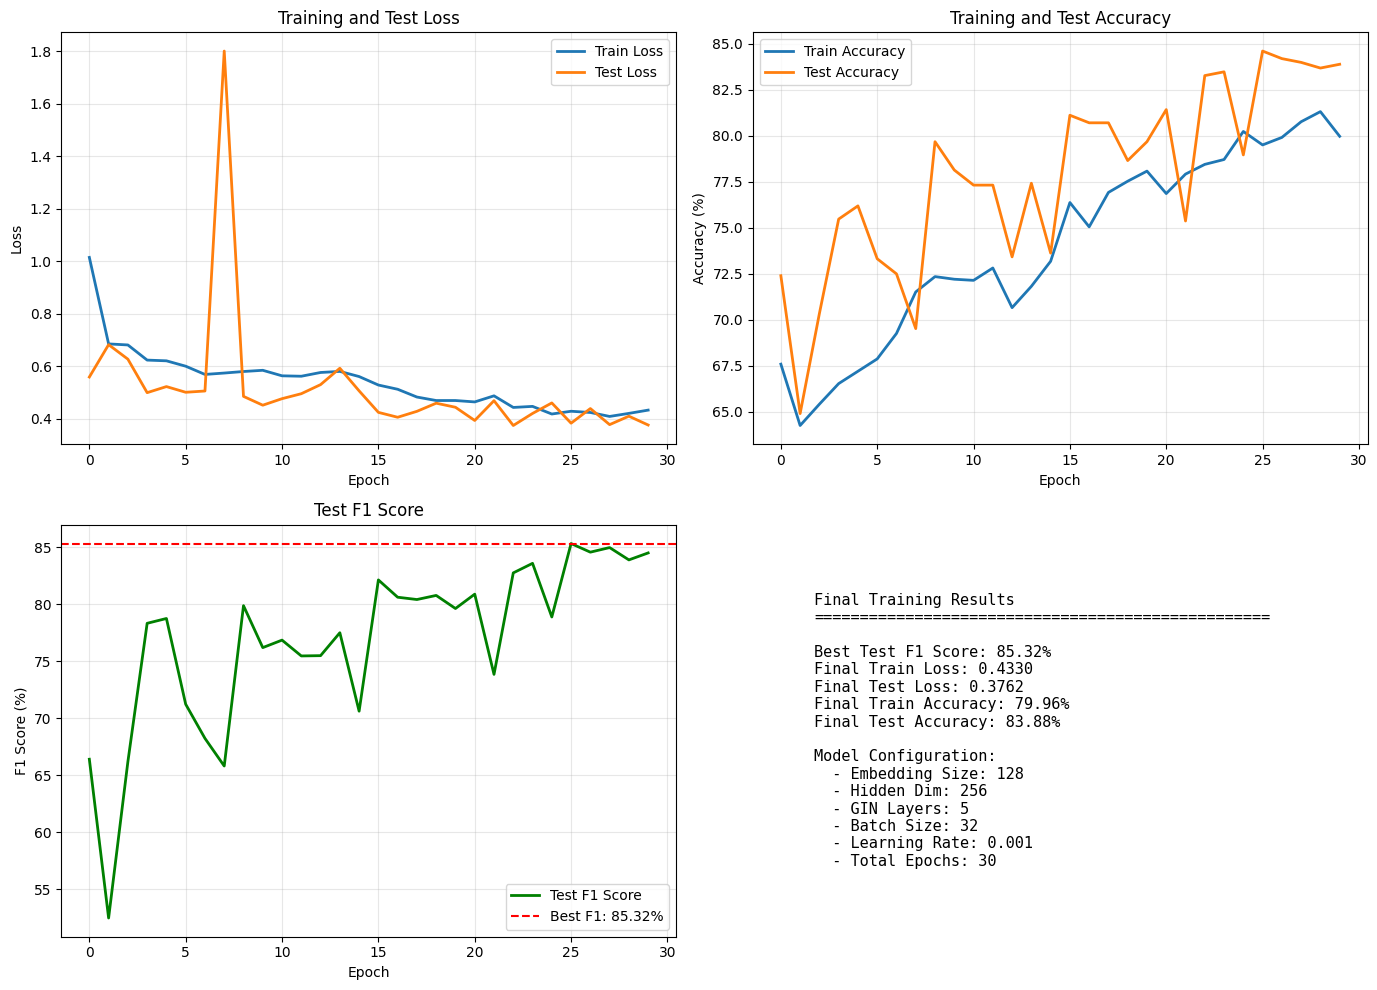

In [57]:
# Plot training curves
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Loss curves
axes[0, 0].plot(train_losses, label='Train Loss', linewidth=2)
axes[0, 0].plot(test_losses, label='Test Loss', linewidth=2)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training and Test Loss')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Accuracy curves
axes[0, 1].plot(train_accs, label='Train Accuracy', linewidth=2)
axes[0, 1].plot(test_accs, label='Test Accuracy', linewidth=2)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy (%)')
axes[0, 1].set_title('Training and Test Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# F1 curve
axes[1, 0].plot(test_f1s, label='Test F1 Score', linewidth=2, color='green')
axes[1, 0].axhline(y=best_test_f1, color='r', linestyle='--', label=f'Best F1: {best_test_f1:.2f}%')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('F1 Score (%)')
axes[1, 0].set_title('Test F1 Score')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Summary statistics
axes[1, 1].axis('off')
summary_text = f"""
Final Training Results
{'='*50}

Best Test F1 Score: {best_test_f1:.2f}%
Final Train Loss: {train_losses[-1]:.4f}
Final Test Loss: {test_losses[-1]:.4f}
Final Train Accuracy: {train_accs[-1]:.2f}%
Final Test Accuracy: {test_accs[-1]:.2f}%

Model Configuration:
  - Embedding Size: {EMBEDDING_SIZE}
  - Hidden Dim: {HIDDEN_DIM}
  - GIN Layers: {NUM_LAYERS}
  - Batch Size: {BATCH_SIZE}
  - Learning Rate: {LEARNING_RATE}
  - Total Epochs: {NUM_EPOCHS}
"""
axes[1, 1].text(0.1, 0.5, summary_text, fontsize=11, family='monospace',
                verticalalignment='center')

plt.tight_layout()
plt.savefig('training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Final Evaluation on Test Set

In [58]:
# Final evaluation with best model
print("Evaluating best model on test set...\n")
final_metrics = evaluate(model, test_loader, criterion, device)

print("="*70)
print("FINAL TEST SET RESULTS")
print("="*70)
print(f"Accuracy:  {final_metrics['accuracy']:.2f}%")
print(f"Precision: {final_metrics['precision']:.2f}%")
print(f"Recall:    {final_metrics['recall']:.2f}%")
print(f"F1 Score:  {final_metrics['f1']:.2f}%")
print(f"AUC-ROC:   {final_metrics['auc']:.4f}")
print("="*70)

Evaluating best model on test set...



FINAL TEST SET RESULTS
Accuracy:  83.88%
Precision: 82.63%
Recall:    86.46%
F1 Score:  84.50%
AUC-ROC:   0.9191


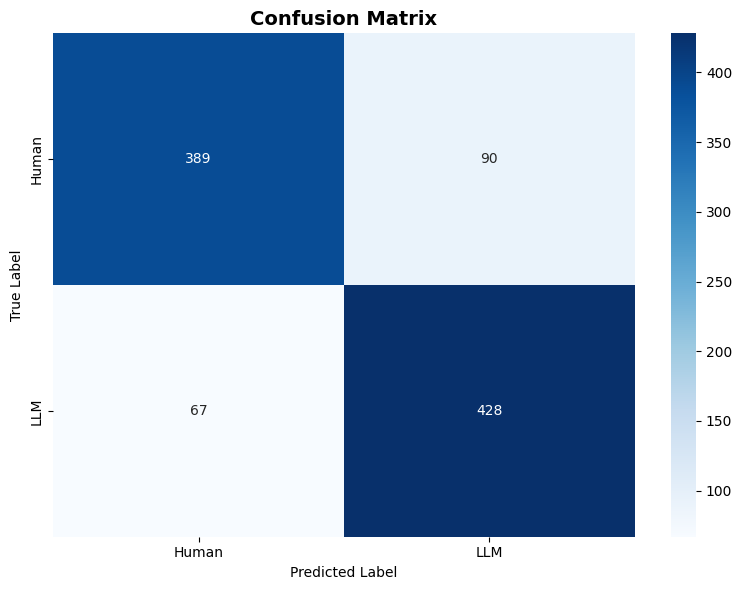


Confusion Matrix:
[[389  90]
 [ 67 428]]


In [59]:
# Confusion matrix
cm = confusion_matrix(final_metrics['labels'], final_metrics['predictions'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['Human', 'LLM'],
            yticklabels=['Human', 'LLM'])
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nConfusion Matrix:")
print(cm)

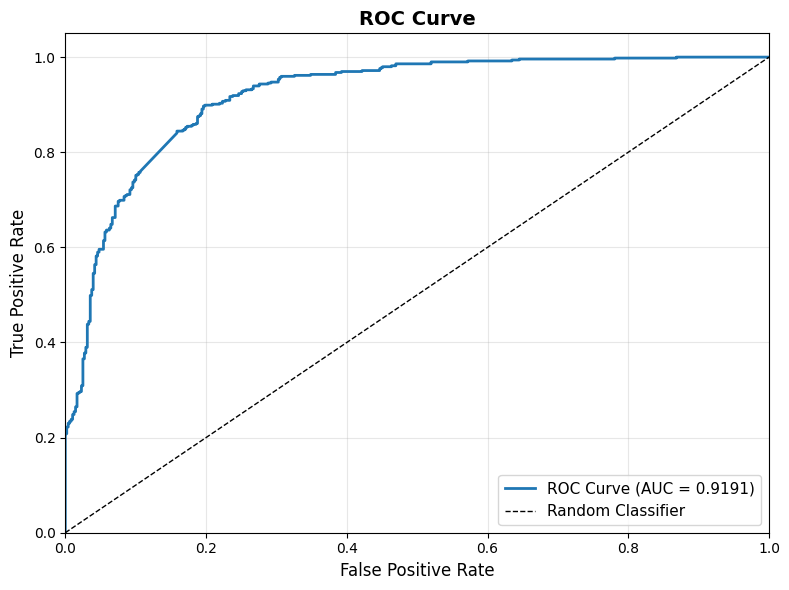

In [60]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(final_metrics['labels'], final_metrics['probabilities'])

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, linewidth=2, label=f'ROC Curve (AUC = {final_metrics["auc"]:.4f})')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('roc_curve.png', dpi=150, bbox_inches='tight')
plt.show()

## 8. Error Analysis

In [61]:
# Analyze misclassifications
predictions = np.array(final_metrics['predictions'])
labels = np.array(final_metrics['labels'])
probabilities = np.array(final_metrics['probabilities'])

# Find misclassified samples
misclassified_idx = np.where(predictions != labels)[0]
correct_idx = np.where(predictions == labels)[0]

print(f"Total samples: {len(labels)}")
print(f"Correctly classified: {len(correct_idx)} ({100*len(correct_idx)/len(labels):.2f}%)")
print(f"Misclassified: {len(misclassified_idx)} ({100*len(misclassified_idx)/len(labels):.2f}%)")

# Breakdown by class
human_misclassified = np.where((predictions != labels) & (labels == 0))[0]
llm_misclassified = np.where((predictions != labels) & (labels == 1))[0]

print(f"\nMisclassified breakdown:")
print(f"  Human → LLM: {len(human_misclassified)} (false positives)")
print(f"  LLM → Human: {len(llm_misclassified)} (false negatives)")

Total samples: 974
Correctly classified: 817 (83.88%)
Misclassified: 157 (16.12%)

Misclassified breakdown:
  Human → LLM: 90 (false positives)
  LLM → Human: 67 (false negatives)


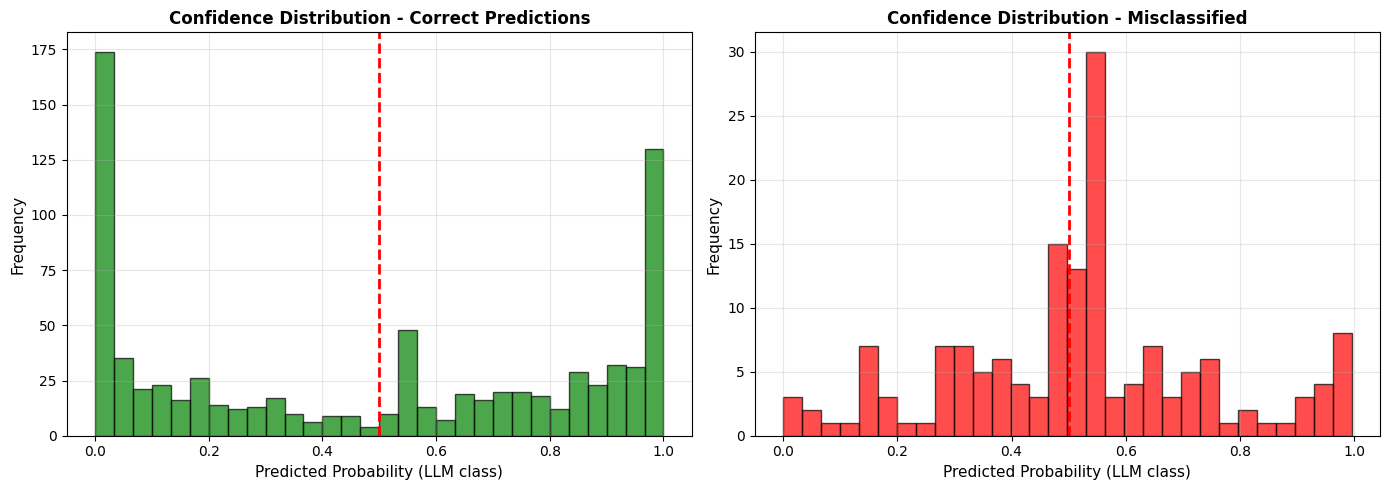

In [62]:
# Confidence distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confidence for correct predictions
correct_probs = probabilities[correct_idx]
axes[0].hist(correct_probs, bins=30, alpha=0.7, color='green', edgecolor='black')
axes[0].axvline(x=0.5, color='r', linestyle='--', linewidth=2)
axes[0].set_xlabel('Predicted Probability (LLM class)', fontsize=11)
axes[0].set_ylabel('Frequency', fontsize=11)
axes[0].set_title('Confidence Distribution - Correct Predictions', fontsize=12, fontweight='bold')
axes[0].grid(alpha=0.3)

# Confidence for misclassified predictions
misclassified_probs = probabilities[misclassified_idx]
axes[1].hist(misclassified_probs, bins=30, alpha=0.7, color='red', edgecolor='black')
axes[1].axvline(x=0.5, color='r', linestyle='--', linewidth=2)
axes[1].set_xlabel('Predicted Probability (LLM class)', fontsize=11)
axes[1].set_ylabel('Frequency', fontsize=11)
axes[1].set_title('Confidence Distribution - Misclassified', fontsize=12, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('confidence_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

## 9. Model Saving and Summary

In [63]:
# Save complete model checkpoint
checkpoint = {
    'model_state_dict': best_model_state,
    'vocab_size': vocab_size,
    'embedding_dim': EMBEDDING_SIZE,
    'hidden_dim': HIDDEN_DIM,
    'num_layers': NUM_LAYERS,
    'max_nodes': MAX_NODES,
    'best_test_f1': best_test_f1,
    'final_metrics': final_metrics,
    'train_losses': train_losses,
    'test_losses': test_losses,
    'train_accs': train_accs,
    'test_accs': test_accs,
    'test_f1s': test_f1s
}

torch.save(checkpoint, 'checkpoint.pth')
print("Complete checkpoint saved to 'checkpoint.pth'")

Complete checkpoint saved to 'checkpoint.pth'


In [64]:
# Save results summary
results_summary = {
    'model_config': {
        'embedding_size': EMBEDDING_SIZE,
        'hidden_dim': HIDDEN_DIM,
        'num_layers': NUM_LAYERS,
        'max_nodes': MAX_NODES,
        'batch_size': BATCH_SIZE,
        'learning_rate': LEARNING_RATE,
        'num_epochs': NUM_EPOCHS
    },
    'final_metrics': {
        'accuracy': float(final_metrics['accuracy']),
        'precision': float(final_metrics['precision']),
        'recall': float(final_metrics['recall']),
        'f1': float(final_metrics['f1']),
        'auc': float(final_metrics['auc'])
    },
    'confusion_matrix': cm.tolist(),
    'dataset_stats': {
        'train_size': len(valid_dataset),
        'test_size': len(test_dataset),
        'vocab_size': vocab_size
    }
}

with open('results_summary.json', 'w') as f:
    json.dump(results_summary, f, indent=2)

print("Results summary saved to 'results_summary.json'")

Results summary saved to 'results_summary.json'


## 10. Sample Predictions

In [65]:
# Show some example predictions
num_examples = 5

print("\n" + "="*70)
print("SAMPLE PREDICTIONS")
print("="*70)

for i in range(min(num_examples, len(test_dataset))):
    sample = test_dataset[i]
    
    # Prepare inputs
    code_graph = sample['code_graph'].unsqueeze(0).to(device)
    contrast_graph = sample['contrast_graph'].unsqueeze(0).to(device)
    code_seq = [sample['code_sequence']]
    contrast_seq = [sample['contrast_sequence']]
    code_num_nodes = [sample['code_num_nodes']]
    contrast_num_nodes = [sample['contrast_num_nodes']]
    
    # Get prediction
    model.eval()
    with torch.no_grad():
        logits = model(code_seq, code_graph, code_num_nodes,
                      contrast_seq, contrast_graph, contrast_num_nodes)
        probs = F.softmax(logits, dim=1)
        pred = torch.argmax(logits, dim=1).item()
        confidence = probs[0][pred].item()
    
    true_label = sample['label'].item()
    
    print(f"\nSample {i+1}:")
    print(f"  Index: {sample['index']}")
    print(f"  True Label: {true_label} ({'Human' if true_label == 0 else 'LLM'})")
    print(f"  Predicted: {pred} ({'Human' if pred == 0 else 'LLM'})")
    print(f"  Confidence: {confidence*100:.2f}%")
    print(f"  Code nodes: {sample['code_num_nodes']}, Contrast nodes: {sample['contrast_num_nodes']}")
    print(f"  {'✓ CORRECT' if pred == true_label else '✗ INCORRECT'}")


SAMPLE PREDICTIONS

Sample 1:
  Index: gp333488
  True Label: 1 (LLM)
  Predicted: 1 (LLM)
  Confidence: 97.96%
  Code nodes: 29, Contrast nodes: 27
  ✓ CORRECT

Sample 2:
  Index: gp254519
  True Label: 1 (LLM)
  Predicted: 1 (LLM)
  Confidence: 99.82%
  Code nodes: 21, Contrast nodes: 18
  ✓ CORRECT

Sample 3:
  Index: gp320381
  True Label: 1 (LLM)
  Predicted: 1 (LLM)
  Confidence: 73.46%
  Code nodes: 63, Contrast nodes: 138
  ✓ CORRECT

Sample 4:
  Index: gp162698
  True Label: 0 (Human)
  Predicted: 0 (Human)
  Confidence: 65.83%
  Code nodes: 33, Contrast nodes: 42
  ✓ CORRECT

Sample 5:
  Index: gp187093
  True Label: 1 (LLM)
  Predicted: 1 (LLM)
  Confidence: 85.39%
  Code nodes: 29, Contrast nodes: 33
  ✓ CORRECT
